In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
import os
#annots = loadmat('C:\\Users\\llinc\\GitHub\\retina_personal\\0406\\merge\\merge_0224_HMM_RL_G2.5_5min_Q100_6.5mW.mat')
%matplotlib inline

In [2]:
# exp_folder = 'D:\\Leo\\0503'
exp_folder = 'C:\\Users\\llinc\\GitHub\\retina_personal\\0503'
exp_folder = 'D:\\Leo\\0503'
G = 4.5
annots = loadmat(exp_folder+'\\merge\\'+'merge_0224_OUsmooth_RL_G'+str(G)+'_5min_Q100_6.5mW_1Hz.mat')

In [3]:
channelnumber =47-1
#os.chdir('C:\\Users\\llinc\\OneDrive\\桌面\\新增資料夾')

In [4]:
## EqualState assign states with equal possibility for input array x
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate

In [5]:
## PIfunc that calculate Unique, Synergy and Redundancy of three unsymmetric varibles
def PIfunc(r, x, v, dt, window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int16')
    Redun =np.zeros(len(bitshift))
    MIxr=np.zeros(len(bitshift))
    MIvr=np.zeros(len(bitshift))
    MIxvR=np.zeros(len(bitshift))
    # shifted data
    # shift>0 => y shifted to positive side
    for i in range(len(bitshift)):
        xx=[]
        vv=[]
        rr=[]
        shift=bitshift[i]
        if shift>0:
            xx=x[shift:]
            vv=v[shift:]
            rr=r[:(-1*shift)]
        elif shift==0:
            xx=x
            vv=v
            rr=r
        elif shift<0:
            xx=x[:shift]
            vv=v[:shift]
            rr=r[(-1*shift):]
        #find weight of each states by 3D histogram 
        xedges = np.append(np.unique(xx),(max(xx)+1))
        vedges = np.append(np.unique(vv),(max(vv)+1))
        redges = np.append(np.unique(rr),(max(rr)+1))
        dat = np.concatenate((xx[:,np.newaxis], vv[:,np.newaxis],rr[:,np.newaxis]), axis=1)
        N, edges = np.histogramdd(dat, bins=(xedges, vedges, redges))
        #Calculate all kinds of probability and make sure the shape of them, 0 -> x, 1 -> v, 2 -> r
        px=(np.sum(N,axis=(1,2))/np.sum(N))[:, np.newaxis, np.newaxis]
        pv=(np.sum(N,axis=(0,2))/np.sum(N))[np.newaxis, :, np.newaxis]
        pr=(np.sum(N,axis=(0,1))/np.sum(N))[np.newaxis ,np.newaxis, :]
        pxv=(np.sum(N,axis=2)/np.sum(N))[:, :, np.newaxis]
        pxr=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis, :]
        pvr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :, :]
        pxvr=(N/np.sum(N))
        
        MIxr[i]=np.nansum(pxr*np.log2(pxr/px/pr))/dt
        MIvr[i]=np.nansum(pvr*np.log2(pvr/pv/pr))/dt
        MIxvR[i]=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
        
        PI_xR = np.nansum(pxr*np.log2(pxr/px/pr), axis = (0,1))
        PI_vR = np.nansum(pvr*np.log2(pvr/pv/pr), axis = (0,1))
        Redun[i] = sum(np.minimum(PI_xR, PI_vR))/dt
    return timeshift, MIxr, MIvr, MIxvR, Redun

(150, 160)

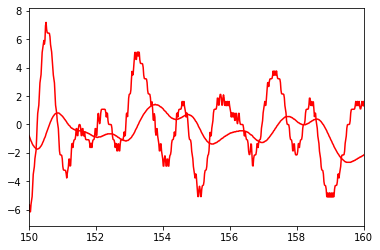

In [6]:
x = np.squeeze(annots['bin_pos'])
x = x.astype(float)
x = (x-np.mean(x))/np.std(x)
dt = 1./60
T=np.squeeze(annots['diode_BT'])
v = ndimage.gaussian_filter1d(x, sigma=1, order=1, mode='wrap') / dt
#v = np.diff(x)/dt
x=x[1:-1]
v=v[1:-1] #cut ends.  V(n) = X(n) -X(n-1)
T=T[1:-1]
#plt.plot(T,L[1:-1], 'm-')
plt.plot(T,x, 'r-')
plt.plot(T,v, 'r-')
plt.xlim(150,160)

In [7]:
x_cor = np.correlate(x, x, "same")
x_cor = x_cor[:int((len(x_cor)+1)/2)+1]
Taxis = np.flip(T[:len(x_cor)]-dt/2)
t_cor = np.interp(0.5*max(x_cor),  x_cor, Taxis)
t_cor

0.7434361774509192

In [8]:
##response
# Model one: simple estimation
window = [-1,1] # second
Ux_peaktime =[]
Uv_peaktime = []
Syn_peaktime = []
Rdn_peaktime = []
Ux_peakH =[]
Uv_peakH = []
Syn_peakH = []
Rdn_peakH = []
deltaTs = np.arange(0.1,5,0.1)
for deltaT in deltaTs:
    r = x+v*deltaT
    #assign states
    edges = np.append(min(r), np.array([np.std(r),2*np.std(r),3*np.std(r)])+np.mean(r));
    rstate=np.zeros(len(r))
    for i in range(4):
        rstate[r>=edges[i]] = i
    #rstate = np.random.poisson(rstate)
    rstate = rstate.astype(int)
    xstate = EqualState(x, 6)
    vstate = EqualState(v, 6)
    #calculate information
    timeshift, MIx, MIv, MIjoint, Redun = PIfunc(rstate, xstate, vstate, dt, window)
    Ux = MIx-Redun
    Uv = MIv-Redun
    Syner = MIjoint-MIx-MIv+Redun
    #plot PI
#     plt.plot(timeshift,Ux, 'r-')
#     plt.plot(timeshift,Uv, 'b-')
#     plt.plot(timeshift,Syner, 'k-')
#     plt.plot(timeshift,Redun, 'g-')
#     plt.title(r'$\delta T=$'+str(deltaT))
#     plt.xlabel('Time(s)')
#     plt.ylabel('Information(bit/s)')
#     plt.gcf().set_size_inches(10.7, 6)
#     plt.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
#     plt.show()
    #find peak
    
    Ux_peaktime.append( timeshift[int(np.mean(np.where(Ux == max(Ux))))])
    Uv_peaktime.append( timeshift[int(np.mean(np.where(Uv == max(Uv))))])
    Syn_peaktime.append( timeshift[int(np.mean(np.where(Syner == max(Syner))))])
    Rdn_peaktime.append( timeshift[int(np.mean(np.where(Redun == max(Redun))))])
    Ux_peakH.append( max(Ux))
    Uv_peakH.append( max(Uv))
    Syn_peakH.append( max(Syner))
    Rdn_peakH.append( max(Redun))

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in multi

In [9]:
Ux_peaktime = np.array(Ux_peaktime)
Uv_peaktime = np.array(Uv_peaktime)
Syn_peaktime = np.array(Syn_peaktime)
Rdn_peaktime = np.array(Rdn_peaktime)
Ux_peakH = np.array(Ux_peakH)
Uv_peakH = np.array(Uv_peakH)
Syn_peakH = np.array(Syn_peakH)
Rdn_peakH = np.array(Rdn_peakH)

In [21]:
np.interp(2.0016404154077834,  (Uv_peakH/Ux_peakH)[:], deltaTs[:])

1.4042203424534292

In [20]:
(Uv_peakH/Ux_peakH)

array([5.06925441e-17, 8.72227016e-06, 4.56546837e-02, 1.81103267e-01,
       3.31230105e-01, 5.08986915e-01, 7.44440872e-01, 9.33795559e-01,
       1.14040135e+00, 1.31863714e+00, 1.51908397e+00, 1.69586093e+00,
       1.83578473e+00, 1.99704085e+00, 2.10602640e+00, 2.25609001e+00,
       2.37869331e+00, 2.48271561e+00, 2.59114382e+00, 2.66141733e+00,
       2.72743587e+00, 2.80339763e+00, 2.88462838e+00, 2.97351892e+00,
       3.00659391e+00, 3.05098029e+00, 3.09927719e+00, 3.13649874e+00,
       3.17793184e+00, 3.23168878e+00, 3.26825161e+00, 3.30937820e+00,
       3.32111624e+00, 3.36934761e+00, 3.41309373e+00, 3.45110311e+00,
       3.49846218e+00, 3.55243377e+00, 3.58775762e+00, 3.64039590e+00,
       3.66995224e+00, 3.70438071e+00, 3.73958999e+00, 3.77224363e+00,
       3.81418142e+00, 3.86598484e+00, 3.88901294e+00, 3.95108494e+00,
       3.96616208e+00])

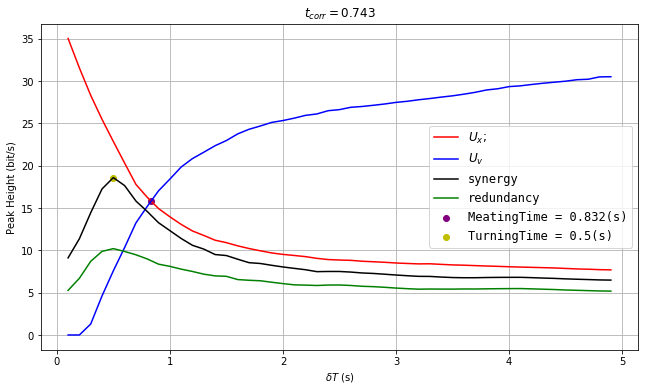

In [11]:
xvMeatingTime = np.interp(1,  Uv_peakH/Ux_peakH, deltaTs)
xvMeatingHeight = np.interp(xvMeatingTime,  deltaTs, Ux_peakH)
plt.plot(deltaTs,Ux_peakH, 'r-')
plt.plot(deltaTs,Uv_peakH, 'b-')
plt.plot(deltaTs,Syn_peakH, 'k-')
plt.plot(deltaTs,Rdn_peakH, 'g-')
plt.scatter(xvMeatingTime, xvMeatingHeight, c = 'purple')
TurningTime = np.squeeze(np.interp(np.where(Syn_peakH == max(Syn_peakH)),  np.arange(len(deltaTs)), deltaTs))
plt.scatter(TurningTime , max(Syn_peakH), c = 'y')
plt.title(r'$t_{corr} = $'+ str(round(t_cor,3)))
plt.xlabel(r'$\delta T$ (s)')
plt.ylabel(r'Peak Height (bit/s)')
plt.grid(True)
plt.gcf().set_size_inches(10.7, 6)
plt.legend((r'$U_x;$', r'$U_v$', 'synergy', 'redundancy', 'MeatingTime = '+str(round(xvMeatingTime,3))+'(s)', 'TurningTime = '+str(TurningTime)+'(s)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
figure = plt.gcf()

In [12]:
save_folder = 'C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\analysis result\\DeltaT vs Tau\\'
# save_folder = 'C:\\Users\\llinc\\GitHub\\python code\\analysis result\\DeltaT vs Tau\\'
name = 'PeakHeights_G='+str(G)+'.tif'
figure.savefig(save_folder+name)

In [13]:
# plt.plot(deltaTs,Ux_peaktime, 'r-')
# plt.plot(deltaTs[0:],Uv_peaktime[0:], 'b-')
# plt.plot(deltaTs,Syn_peaktime, 'k-')
# plt.plot(deltaTs,Rdn_peaktime, 'g-')
# plt.title(r'$t_{corr} = $'+ str(round(t_cor,3)))
# plt.xlabel(r'$\delta T (s)$')
# plt.ylabel('Peak time (s)')
# plt.gcf().set_size_inches(10.7, 6)
# plt.legend( (r'$U_x ;$ '+str(round(Ux_peak[-1],3)), r'$U_v;$ '+str(round(Uv_peak[-1],3)), 'synergy; '+str(round(Syn_peak[-1],3)), 'redundancy; '+str(round(Rdn_peak[-1],3))), loc='best', prop={'size': 'large', 'family': 'monospace'})
# plt.grid(True)
# figure = plt.gcf()

In [14]:
# save_folder = 'C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\analysis result\\DeltaT vs Tau\\'
# save_folder = 'C:\\Users\\llinc\\GitHub\\python code\\analysis result\\DeltaT vs Tau\\'
# name = 'PeakTimes_G='+str(G)+'.tif'
# figure.savefig(save_folder+name)